In [2]:
import json
import re
import sys
import os
import ast

from tqdm import tqdm
from collections import Counter
from pathlib import Path

In [3]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint

from pandas.io.json import json_normalize

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
import nltk
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from gensim.models.fasttext import FastText
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

from nltk.corpus import stopwords
import gensim.downloader as api
import string
from sklearn.semi_supervised import LabelSpreading, LabelPropagation

/home/g/g01107/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# **`Clean and Process Data `**

In [6]:
import nltk
nltk.download() #Dowload stopwords, only needed to update after first download

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> stopword
Command 'stopword' unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


      Package stopwords is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [4]:
#Opens the data and reorganizes it by tweets instead of by events
with open('./Trec_data/labeled_by_event.json') as f:
    js = json.load(f)
df = json_normalize(data=js['events'], record_path='tweets')
df.to_json('./Trec_data/labeled.json', orient='records', lines=True)

df

,eventID,eventType,postID,postCategories,postPriority,postText
0,stormJorge2020,typhoon,1231307896362807298,[Irrelevant],Low,Flood Warning: River Severn at Hanley Castle a...
1,stormJorge2020,typhoon,1231569665043976192,[Irrelevant],Low,Flood Warning: River Ouse at Naburn Lock 12:46...
2,stormJorge2020,typhoon,1232264304067477504,[Irrelevant],Low,Our Assistant Director of Care and Support kin...
3,stormJorge2020,typhoon,1232070602778959872,[Irrelevant],Low,@hollywills please can you help support @HopeR...
4,stormJorge2020,typhoon,1232648900105965568,[Irrelevant],Low,Police order 'immediate evacuation' in Shropsh...
...,...,...,...,...,...,...
91510,whaleyBridgeCollapse2020,flood,1155430270457323520,[Irrelevant],Low,Flood Alert: River Ecclesbourne in Derbyshire ...
91511,whaleyBridgeCollapse2020,flood,1156993824591417346,"[Location, EmergingThreats, MultimediaShare, N...",High,Dam at Whaley Bridge in Peak District threaten...
91512,whaleyBridgeCollapse2020,flood,1157020257388769280,"[ThirdPartyObservation, Location, MultimediaSh...",Low,Floods in Whaley Bridge today.\nhttps://t.co/7...
91513,whaleyBridgeCollapse2020,flood,1156926115069485056,"[MovePeople, ThirdPartyObservation, Location, ...",Critical,Evacuation of Whaley Bridge | Derbyshire Const...


In [5]:
stop_words = stopwords.words('english')
stop_words.extend(["http", "https", "rt", "@", ":", "t.co", "co", "amp", "&amp;", "...", "\n", "\r"])
stop_words.extend(string.punctuation)

In [6]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = str(sent)
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)


In [7]:
# Look into what shape this ./labeled.json
df = pd.read_json("./Trec_data/labeled.json", orient='records', lines=True)
data = df.postText.values.tolist()
data_words = list(sent_to_words(data))

In [8]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_trf', disable=['parser', 'ner'])
    for sent in tqdm(texts): #Code to see that it is progressing
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

In [13]:
data_ready = process_words(data_words)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000


In [14]:
df['processed_text']=data_ready
df.to_json('./Trec_data/PR_all_Labeled.json', orient='records', lines=True)
df

,eventID,eventType,postID,postCategories,postPriority,postText,processed_text
0,stormJorge2020,typhoon,1231307896362807296,[Irrelevant],Low,Flood Warning: River Severn at Hanley Castle a...,"[flood, february]"
1,stormJorge2020,typhoon,1231569665043976192,[Irrelevant],Low,Flood Warning: River Ouse at Naburn Lock 12:46...,"[flood, naburn_lock, february]"
2,stormJorge2020,typhoon,1232264304067477504,[Irrelevant],Low,Our Assistant Director of Care and Support kin...,"[assistant, director, care, support, kindly, l..."
3,stormJorge2020,typhoon,1232070602778959872,[Irrelevant],Low,@hollywills please can you help support @HopeR...,"[help, support, following, recent, flooding, c..."
4,stormJorge2020,typhoon,1232648900105965568,[Irrelevant],Low,Police order 'immediate evacuation' in Shropsh...,"[police, order, flooding, send]"
...,...,...,...,...,...,...,...
91510,whaleyBridgeCollapse2020,flood,1155430270457323520,[Irrelevant],Low,Flood Alert: River Ecclesbourne in Derbyshire ...,"[flood, alert, river]"
91511,whaleyBridgeCollapse2020,flood,1156993824591417344,"[Location, EmergingThreats, MultimediaShare, N...",High,Dam at Whaley Bridge in Peak District threaten...,"[peak, district, threaten, burst, gofh, pb, nc..."
91512,whaleyBridgeCollapse2020,flood,1157020257388769280,"[ThirdPartyObservation, Location, MultimediaSh...",Low,Floods in Whaley Bridge today.\nhttps://t.co/7...,"[flood, today]"
91513,whaleyBridgeCollapse2020,flood,1156926115069485056,"[MovePeople, ThirdPartyObservation, Location, ...",Critical,Evacuation of Whaley Bridge | Derbyshire Const...,"[evacuation, constabulary]"


In [ ]:
#What does this do?
#cp -a ./PR_all_Labeled.json  gdrive/My\ Drive/Code/

# Generating Similarity Scores and Matrix
### **Mean and Cosine Similarity(each event with all other event-types)**


In [15]:
import pickle
#import logging
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.pipeline import make_pipeline
from scipy import sparse
import numpy as np
import os.path
import re
from tqdm import tqdm
import warnings
import pandas as pd

In [16]:
data = pd.read_json("./Trec_data/PR_all_Labeled.json", orient='records',lines=True)

In [26]:
# remove irrelevant tweets
data = pd.read_json("./Trec_data/PR_all_Labeled.json", orient='records',lines=True)
#data.loc[(data.eventid == 'parisAttacks2015'),'event_type']='shooting' #Do we need?
def label_ir_tweets(postCategories):

    if 'Irrelevant' in postCategories:
        return 1
    else:
        return 0
data['ir'] = [label_ir_tweets(x) for x in data['postCategories']]
data=data.query("ir == 0")
data.drop(columns=['ir'], inplace=True)
#data=data.query("label ==1")

In [27]:
df['postCategories'].explode().unique()

array(['Irrelevant', 'Location', 'MultimediaShare',
       'ContextualInformation', 'Weather', 'Discussion', 'Hashtags',
       'News', 'Official', 'EmergingThreats', 'FirstPartyObservation',
       'Factoid', 'ThirdPartyObservation', 'MovePeople', 'Sentiment',
       'Advice', 'GoodsServices', 'Donations', 'ServiceAvailable',
       'SearchAndRescue', 'NewSubEvent', nan, 'Volunteer', 'CleanUp',
       'InformationWanted', 'OriginalEvent'], dtype=object)

In [28]:
df['eventType'].unique()

array(['typhoon', 'storm', 'wildfire', 'covid', 'flood', 'bombing',
       'shooting', 'earthquake', 'explosion', 'hostage', 'fire',
       'tornado'], dtype=object)

In [30]:
#Removes rows that have no processed _text (Dropped a third)
data['l'] = data.apply(lambda row: len(row['processed_text']), axis=1)
data= data.query("l >1")
data.drop(columns=['l'], inplace=True)
data

,eventID,eventType,postID,postCategories,postPriority,postText,processed_text,ir
602,tennesseeDerecho2020,storm,1257045884560461824,"[Location, MultimediaShare, ContextualInformat...",Low,Nashville Mayor Floats 32 Percent Property Tax...,"[mayor, float, percent, property, tax, hike, c...",0
604,tennesseeDerecho2020,storm,1256433237301137408,"[Weather, Location]",Low,Summerdale Bartlett TN Weather 11:00 PM Temp: ...,"[tn, weather, pm, bar, change, rain, today, mo...",0
605,tennesseeDerecho2020,storm,1256913902224334848,"[Weather, Location, Discussion]",Low,"@tanueki TN Air 001, Mac tower.\nWind 60 degre...","[tn, air, mac, tower, wind, degree, knot, runw...",0
606,tennesseeDerecho2020,storm,1257044059593588736,"[Weather, Location, MultimediaShare, Hashtags,...",High,#STORM12ALERT SEVERE THUNDERSTORM WARNING for ...,"[storm, alert, warning, county, tn, pm, wd]",0
607,tennesseeDerecho2020,storm,1257058413298712576,"[Weather, Location, MultimediaShare, Official,...",High,Nashville metro find your Safe Spots now. We a...,"[metro, find, safe, spot, roughly, minute, awa...",0
...,...,...,...,...,...,...,...,...
91509,whaleyBridgeCollapse2020,flood,1156949866402189312,"[Location, EmergingThreats, MultimediaShare, F...",High,Oh no #WhaleyBridge has collapsed (minor). Be ...,"[collapse, minor, safe]",0
91511,whaleyBridgeCollapse2020,flood,1156993824591417344,"[Location, EmergingThreats, MultimediaShare, N...",High,Dam at Whaley Bridge in Peak District threaten...,"[peak, district, threaten, burst, gofh, pb, nc...",0
91512,whaleyBridgeCollapse2020,flood,1157020257388769280,"[ThirdPartyObservation, Location, MultimediaSh...",Low,Floods in Whaley Bridge today.\nhttps://t.co/7...,"[flood, today]",0
91513,whaleyBridgeCollapse2020,flood,1156926115069485056,"[MovePeople, ThirdPartyObservation, Location, ...",Critical,Evacuation of Whaley Bridge | Derbyshire Const...,"[evacuation, constabulary]",0


In [ ]:
#This would run through the ssh oopsy, do not run
#pip install -U sentence-transformers

In [42]:
# generate sentnece embedding
class SBERT:

    def __init__(self, lang="en"):
        from sentence_transformers import SentenceTransformer
        self.name = "SBERT"
        if lang == "fr":
            self.model = SentenceTransformer(
                "/home/bmazoyer/Dev/pytorch_bert/output/sts_fr_long_multilingual_bert-2019-10-01_15-07-03")
        elif lang == "en": #Does this need to be changed?
            self.model = SentenceTransformer(
                # "bert-large-nli-stsb-mean-tokens"
                "roberta-large-nli-stsb-mean-tokens"
            )
# roberta-large-nli-stsb-mean-tokens
    def compute_vectors(self, data):
        data["postText"] = data.postText.str.slice(0, 500)
        vectors = np.array(self.model.encode(data.postText.tolist()))
        return vectors

In [43]:
sbert=SBERT()

In [45]:
v=sbert.compute_vectors(data)
data['sbert_emb']=[item for item in v]

In [46]:
from numpy import dot
from numpy.linalg import norm

In [126]:
#Can't handle the list of postType
def generate_similarity_matrix (frame, grouping, group_types):
    #generate similarity scores dataframe
    group_ranks=pd.DataFrame()
    for heldout_event in group_types:

        training = frame[frame[grouping] != heldout_event]
        test = frame[frame[grouping] == heldout_event]

        ref=np.mean(test["sbert_emb"], axis=0)

        grpups=training.groupby(grouping) #Might need to be changed 
        ranks={}
        ranks["reference-group"]=heldout_event
        for name, group in grpups:
           val=np.mean(group["sbert_emb"], axis=0)
           cos_sim = dot(ref, val)/(norm(ref)*norm(val))
           ranks[name]=cos_sim

        # event_ranks[heldout_event]=ranks
        #print(ranks)
        group_ranks = group_ranks.append(ranks, ignore_index=True)
    group_ranks.set_index("reference-group",inplace=True)
    #group_ranks=frame.groupby(grouping) #Does the label==1 need to change?
    return group_ranks


In [127]:
import seaborn as sns

In [128]:
#is this even required? and is this based off the 4 different sources?
events=[ 
'2014_Philippines_Typhoon_Hagupi',
 '2015_Cyclone_Pam',
 'albertaFloods2013',
 'albertaWildfires2019',
 'australiaBushfire2013',
 'cycloneKenneth2019',
 'fireYMM2016',
 'hurricaneFlorence2018',
 'keralaFloods2019',
 'manilaFloods2013',
 'philipinnesFloods2012',
 'queenslandFloods2013',
 'southAfricaFloods2019',
 'typhoonHagupit2014',
 'typhoonYolanda2013'
]
event_types=['typhoon', 'storm', 'wildfire', 'covid', 'flood',
       'shooting', 'earthquake', 'explosion', 'hostage', 'fire',
       'tornado']
event_types

['typhoon',
 'storm',
 'wildfire',
 'covid',
 'flood',
 'shooting',
 'earthquake',
 'explosion',
 'hostage',
 'fire',
 'tornado']

In [131]:
event_ranks = generate_similarity_matrix(data, 'eventType', event_types)
event_ranks = event_ranks.replace(np.nan, 1)
event_ranks.to_csv("./Trec_data/event_ranks.csv")
event_ranks

,covid,earthquake,explosion,fire,flood,hostage,shooting,storm,tornado,wildfire,typhoon
reference-group,,,,,,,,,,,
typhoon,0.697034,0.770658,0.609508,0.657959,0.864774,0.493680,0.457430,0.866822,0.688201,0.758405,1.000000
storm,0.639897,0.687959,0.610657,0.579766,0.698131,0.476903,0.498314,1.000000,0.767818,0.724113,0.866822
wildfire,0.669187,0.602077,0.616383,0.699206,0.710327,0.471162,0.489794,0.724113,0.718727,1.000000,0.758405
covid,1.000000,0.631319,0.578333,0.594831,0.599704,0.563233,0.608073,0.639897,0.634992,0.669187,0.697034
flood,0.599704,0.672112,0.544272,0.648529,1.000000,0.441061,0.419183,0.698131,0.595095,0.710327,0.864774
shooting,0.608073,0.468368,0.618979,0.497041,0.419183,0.644409,1.000000,0.498314,0.555066,0.489794,0.457430
earthquake,0.631319,1.000000,0.684989,0.617918,0.672112,0.425259,0.468368,0.687959,0.655955,0.602077,0.770658
explosion,0.578333,0.684989,1.000000,0.684461,0.544272,0.448838,0.618979,0.610657,0.743388,0.616383,0.609508
hostage,0.563233,0.425259,0.448838,0.478218,0.441061,1.000000,0.644409,0.476903,0.474415,0.471162,0.493680


In [138]:
critical_types=['Low', 'Medium', 'High', 'Critical']

In [139]:
critical_ranks = generate_similarity_matrix(data, 'postPriority', critical_types) #check what this variable is called in the dataframe
critical_ranks = critical_ranks.replace(np.nan, 1)
critical_ranks.to_csv("./Trec_data/critical_ranks.csv")
critical_ranks

,Critical,High,Medium,Low
reference-group,,,,
Low,0.912780,0.949977,0.965868,1.000000
Medium,0.919304,0.972318,1.000000,0.965868
High,0.945202,1.000000,0.972318,0.949977
Critical,1.000000,0.945202,0.919304,0.912780


In [136]:
info_types=df['postCategories'].explode().unique() #double check that this is string based
info_types

array(['Irrelevant', 'Location', 'MultimediaShare',
       'ContextualInformation', 'Weather', 'Discussion', 'Hashtags',
       'News', 'Official', 'EmergingThreats', 'FirstPartyObservation',
       'Factoid', 'ThirdPartyObservation', 'MovePeople', 'Sentiment',
       'Advice', 'GoodsServices', 'Donations', 'ServiceAvailable',
       'SearchAndRescue', 'NewSubEvent', nan, 'Volunteer', 'CleanUp',
       'InformationWanted', 'OriginalEvent'], dtype=object)

In [137]:
info_ranks = generate_similarity_matrix(data, 'postCategories', info_types) #check what this variable is called in the dataframe
info_ranks = info_ranks.replace(np.nan, 1)
info_ranks.to_csv("./Trec_data/info_ranks.csv")
info_ranks

TypeError: unhashable type: 'list'

In [ ]:
event_ranks.from_csv("./Trec_data/event_ranks.csv")
info_ranks.from_csv("./Trec_data/info_ranks.csv")
critical_ranks.from_csv("./Trec_data/critical_ranks.csv")

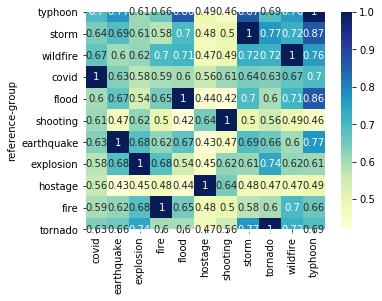

In [135]:
# Visualize similarity matrix for event type using heatmap
#event_ranks.set_index("reference-group",inplace=True)
p1 = sns.heatmap(event_ranks,cmap="YlGnBu", annot=True)

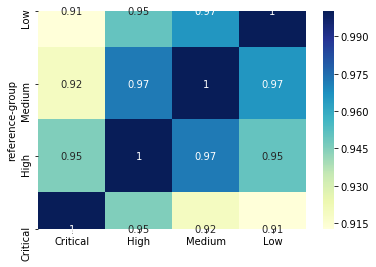

In [141]:
# Visualize similarity matrix for info type using heatmap
#critical_ranks.set_index("reference-group",inplace=True)
p2 = sns.heatmap(critical_ranks,cmap="YlGnBu", annot=True)

In [ ]:
# Visualize similarity matrix for info type using heatmap
#info_ranks.set_index("reference-group",inplace=True)
p3 = sns.heatmap(info_ranks,cmap="YlGnBu", annot=True)